In [1]:
import sys
import keras
import tensorflow as tf
import cv2 as cv
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, confusion_matrix, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv1D, MaxPool1D, BatchNormalization, Dropout, LSTM
from keras.utils.vis_utils import plot_model

from multiprocessing import Process, Value

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
# preprocessing
def read_images(df):
    TRAIN_PATH = "train/"
    X_valid = []
    y_valid = []
    X_train = []
    y_train = []
    for index, row in df.iterrows():
        image_path = TRAIN_PATH + row.id
        # read images
        image = cv.imread(image_path)

        # split into validation and train
        valid = np.random.rand()
        if valid <= 0.1:
            # normalize data if it's for validation
            for i in augment_images(image, valid=True):
                X_valid.append(i)
                y_valid.append(row.label - 1)
        else:
            # normalize and augment otherwise
            for i in augment_images(image):
                X_train.append(i)
                y_train.append(row.label - 1)

    return np.array(X_train), np.array(y_train), np.array(X_valid), np.array(y_valid)


def augment_images(image, valid=False):

    # gamma correction decrease
    def gamma(images):
        def gammaCorrection(src, gamma):
            invGamma = 1 / gamma
            table = [((i / 255) ** invGamma) * 255 for i in range(256)]
            table = np.array(table, np.uint8)
            return cv.LUT(src, table)
        
        lst = []
        for i in images:
            lst.append(gammaCorrection(i,0.5))
        return lst
    
    # flip and rotate images
    def orientation(images):
        lst = []
        for i in images:
            lst.append(cv.flip(i, 1))
            lst.append(cv.flip(i, 0))
            lst.append(cv.rotate(i, cv.ROTATE_180))
        return lst
        
    # turn images to grayscale
    def to_grayscale(images):
        lst = []
        for i in images:
            lst.append(cv.cvtColor(i, cv.COLOR_BGR2GRAY))
        
        return lst
    
    # normalize images
    def normalize(images):
        lst = []
        for i in images:
            lst.append(i/255)
        return lst
        
        
    augmented = []
    augmented.append(image)
    
    if valid == False:
        augmented = orientation(augmented) + augmented
        augmented = gamma(augmented) + augmented

    
    augmented = to_grayscale(augmented) 
    augmented = normalize(augmented)
    
    return np.array(augmented)

In [4]:
## Models

# CNN+LSTM GRAY batch size 512  epochs 20 
def build_model(nr_labels):
    model = Sequential()
    model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(128, 55)))
    model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))

    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPool1D(2))


    model.add(LSTM(128, return_sequences=True, dropout=0.2))
    model.add(LSTM(128, return_sequences=False, dropout=0.2))

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))   
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(nr_labels, activation='softmax'))
    return model

# #CNN GRAY batch size 512  epochs 20 
# def build_model(nr_labels):
#     model = Sequential()
#     model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu', input_shape=(128, 55)))
#     model.add(Conv1D(128, kernel_size=3, padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool1D(2))

#     model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
#     model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu'))
#     model.add(BatchNormalization())
#     model.add(MaxPool1D(2))


#     model.add(Flatten())    
#     model.add(Dense(128, activation='relu'))
#     model.add(Dropout(0.2))   
#     model.add(Dense(64, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(Dense(nr_labels, activation='softmax'))
#     return model


# set model optimizer, loss function, metrics
def build_compiled_model(optimizer="adam"):
    model = build_model(nr_labels=5)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
## 5 fold cross validation on training data

# read data without splitting for cross validation
def read_pure_data(df):
    TRAIN_PATH = "train/"
    X_train = []
    y_train = []
    for index, row in df.iterrows():
        image_path = TRAIN_PATH + row.id
        image = cv.imread(image_path)
        X_train.append(image)
        y_train.append(row.label - 1)
        
    return np.array(X_train), np.array(y_train)


# grayscale normalize and augment data
def aug_cross_validation(X, y, valid):
    X_aug = []
    y_aug = []
    for index in range(len(X)):
        image = X[index]
        label = y[index]
        for i in augment_images(image, valid=valid):
            X_aug.append(i)
            y_aug.append(label)
            
    return np.array(X_aug), np.array(y_aug)


def cross_validation(df):
    X, y = read_pure_data(df)
    # split in 5 folds
    k_fold = KFold(n_splits=5, random_state=1, shuffle=True)
    # for each fold
    for train_index, test_index in k_fold.split(X, y):
        # build a new model
        model = None
        model = build_compiled_model()
        # normalize, grayscale and augment the training data
        X_train, y_train = aug_cross_validation(X[train_index], y[train_index], valid=False)
        # normalize and grayscale the test data
        X_test, y_test = aug_cross_validation(X[test_index], y[test_index], valid=True)         

        # fit the model
        history = model.fit(x=X_train, y=y_train, batch_size=256, epochs=20, verbose=False)
        # get predictions
        y_pred = np.argmax(model.predict(X_test), axis=1)
        
        # compute scores
        print('MAE: %.2f' % mean_absolute_error(y_test, y_pred))
        print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

        # clear ram
        del history
        del model
        del X_train
        del X_test
        del y_train
        del y_test
        # clear gpu memory
        keras.backend.clear_session()


In [7]:
def train_model_and_show_metrics(df):
    # read data
    X_train, y_train, X_valid, y_valid = read_images(df)
    
    # build model
    model = build_compiled_model()
    model.summary()
    # plot model graph
    plot_model(model, show_shapes=True, show_layer_names=True)
    plt.show()
    # train model
    history = model.fit(x=X_train, y=y_train, batch_size=512, epochs=20, validation_data=(X_valid, y_valid), shuffle=True)
    # get predictions
    y_pred = np.argmax(model.predict(X_valid), axis=1)
    
    # compute metrics
    print('On validation data:')
    print('Accuracy: %.2f' % accuracy_score(y_valid, y_pred))
    print('Precision: %.2f' % precision_score(y_valid, y_pred , average="macro"))
    print('Recall: %.2f' % recall_score(y_valid, y_pred , average="macro"))
    print('F1 Score: %.2f' % f1_score(y_valid, y_pred , average="macro"))
    print('MAE: %.2f' % mean_absolute_error(y_valid, y_pred))
    
    
    # plot graphs
    metrics_df = pd.DataFrame(history.history).reset_index().rename(columns={"index": "epoch"})
    metrics_df['epoch'] = metrics_df['epoch'] + 1
    acc_df = metrics_df[['epoch', 'accuracy', 'val_accuracy']].melt('epoch', var_name='cols', value_name='vals')
    loss_df = metrics_df[['epoch', 'loss', 'val_loss']].melt('epoch', var_name='cols', value_name='vals')
    sns.lineplot(data=acc_df, x='epoch', y='vals', hue='cols')
    plt.show()
    sns.lineplot(data=loss_df, x='epoch', y='vals', hue='cols')
    plt.show()
    
    # plot confusion matrix
    df_cm = pd.DataFrame(confusion_matrix(y_valid, y_pred), index=[1,2,3,4,5], columns=[1,2,3,4,5])
    plt.figure(figsize = (10,7))
    sns.heatmap(df_cm, annot=True,  linewidths=.5, fmt='d', cmap=sns.cubehelix_palette(as_cmap=True))
    plt.show()


In [8]:
# write submission
def write_predictions(model):
    TEST_PATH = "test/"
    df = pd.read_csv('test.csv')
    X_test = []
    for index, row in df.iterrows():
        image_path = TEST_PATH + row.id
        image = cv.imread(image_path, 0)/255
        X_test.append(image)
    X_test = np.array(X_test)
    df['label'] = np.argmax(model.predict(X_test), 1) + 1
    df.to_csv('submission.csv', index=False)

In [9]:
# read data from csv into dataframe
df = pd.read_csv('train.csv')

In [10]:
# run cross validation
cross_validation(df)

MAE: 0.44
Accuracy: 0.70
48512
MAE: 0.43
Accuracy: 0.71
48681
MAE: 0.45
Accuracy: 0.70
48681
MAE: 0.41
Accuracy: 0.71
48681
MAE: 0.45
Accuracy: 0.70
48681


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 128, 64)           10624     
                                                                 
 conv1d_1 (Conv1D)           (None, 128, 128)          24704     
                                                                 
 batch_normalization (BatchN  (None, 128, 128)         512       
 ormalization)                                                   
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 128)          0         
 )                                                               
                                                                 
 conv1d_2 (Conv1D)           (None, 64, 256)           98560     
                                                                 
 conv1d_3 (Conv1D)           (None, 64, 256)           1

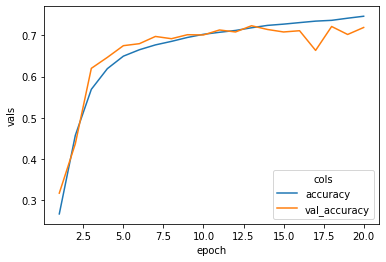

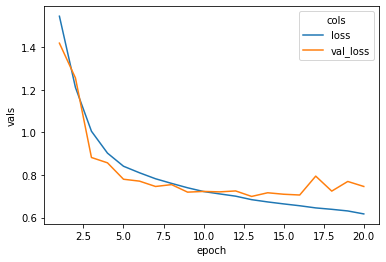

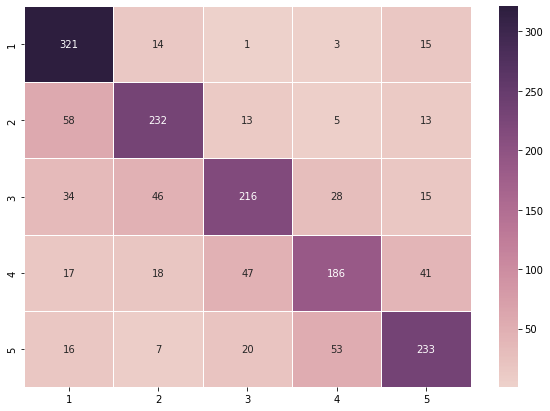

In [12]:
# train model and show metrics
train_model_and_show_metrics(df)

In [13]:
# save model and write predictions
model.save("model.h5")
write_predictions(model)